Dynamic Computational Graph in PyTorch
=======================================

Computational Graphs allow a deep learning framework to do additional bookkeeping to implement automatic gradient differentiation needed to obtain gradients of parameters during training. A computational graph is a DAG (directed acyclic graph), where the nodes are the mathematical operations, such as multiplication and addition. The inputs to the operations are the incoming edges and the output of each operation is the outgoing edge. 

Static frameworks such as Teano, Caffe and TensorFlow (< v1.7) require the computational graphs to be first declared , compiled and the excuted. Although this leads to extremely efficient implementations (useful in production and mobile settings), it can become quite cumberson during research and development. Modern frames like Chainer, DyNet and Pytorch, implement Dynamic Computational Graphs to allow for a more flexible, imperative style of development, without needing to compile the models before every excution. Dynamic computational graphs are especially useful in modelling NLP tasks as each input could potentially result in a different graph structure. As of Version 1.7, TensorFlow has an eager excution that `tf.Tensor` objects reference concrete values instead of symbolic handles to nodes in a computational graph. This is a similar to the PyTorch's dynamic computational graph idea. 

In [3]:
import torch
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'


## Training Data Preparation

We use the same linear model data preparation process here. 

In [4]:
true_b = 1
true_w = 2
N = 100
# Data Generation
np.random.seed(42)
x = np.random.rand(N, 1)
epsilon = (.1 * np.random.randn(N, 1))
y = true_b + true_w * x + epsilon

# Shuffles the indices
idx = np.arange(N)
np.random.shuffle(idx)
# Uses first 80 random indices for train
train_idx = idx[:int(N*.8)]
# Uses the remaining indices for validation
val_idx = idx[int(N*.8):]
# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

# Our data was in Numpy arrays, but we need to transform them
# into PyTorch's Tensors and then we send them to the
# chosen device
x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

## Using `torchviz` to visualise computation graph 

In [5]:
from torch import nn
from torchviz import make_dot, make_dot_from_trace

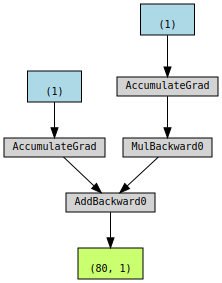

In [6]:
# Step 0 - Initializes parameters "b" and "w" randomly
torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, \
    dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
    dtype=torch.float, device=device)
# Step 1 - Computes our model's predicted output 
#        - forward pass
yhat = b + w * x_train_tensor
# Step 2 - Computes the loss
error = (yhat - y_train_tensor)
loss = (error ** 2).mean()
# We can try plotting the graph for any python variable:
# yhat, error, loss...
make_dot(yhat)

Let's take a closer look at its components:
- blue boxes ((1)s): these boxes correspond to the tensors we use as parameters, the ones we're asking PyTorch to compute gradients for
- gray boxes (MulBackward0 and AddBackward0): a Python operation that involves a gradient-computing tensor or its dependencies
- green box ((80, 1)): the tensor used as the starting point for the computation of gradients (assuming the backward() method is called from the variable used to visualize the graph) — they are computed from the bottom-up in a graph 

Now, take a closer look at the gray box (AddBackward0) at the bottom of the graph: two arrows are
pointing to it since it is adding up two variables, $b$, and $w\times x$. But the gray box (MulBackward0) of the same graph: it is performing a multiplication, namely, $w \times x$. But there is only one arrow pointing to it! The arrow comes from the blue box that corresponds to our parameter $w$.

:::{admonition} "Why don’t we have a box for our data (x)?"
:class: tip
The answer is: we do not compute gradients for it!
:::

## No gradient tracking for `b`

:::{important}
Even though there are more tensors involved in the operations performed by
the computation graph, it only shows **gradient-computing tensors** and its
dependencies.
:::

Let's try to set b to be a non-gradient computing tensor and visualise the computational graph.

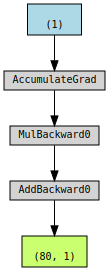

In [7]:
b_nograd = torch.randn(1, requires_grad=False, \
dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
dtype=torch.float, device=device)
yhat = b_nograd + w * x_train_tensor
make_dot(yhat)

## Computational Graph with branches

Let's look at how computational graph deals with if statement. Note the code does not do anything sensible, purely for visualisation and demonstration purposes.

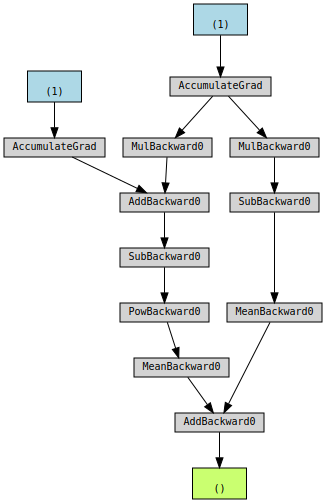

In [9]:
b = torch.randn(1, requires_grad=True, \
dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, \
dtype=torch.float, device=device)
yhat = b + w * x_train_tensor
error = yhat - y_train_tensor
loss = (error ** 2).mean()
# this makes no sense!!
if loss > 0:
    yhat2 = w * x_train_tensor
    error2 = yhat2 - y_train_tensor
# neither does this :-)
loss += error2.mean()
make_dot(loss)